# Digital Image Processing: DATA 56600-002 
## Image Denoising with CNN
### Seth Howells


__Very Important!!!__
Make sure to using GPU runtime for this notebook, otherwise the model training will be extrememly slow, by following:
* Go to _Runtime_ tab in the menu bar (top of the notebook)
* select _Change runtime type_
* Select _GPU_ and then hit _Save_

This Colab notebook uses convolutional neural networks (CNNs) to de-noise malignant tumor images. In order to assess CNNs ability to de-noise images, a helper function creates a copy of the target image and adds random noise to the image. The copy of noise images serves as the input in this analysis. To serve as a baseline of de-noising images, the target images remain unchanged, and can otherwise be referred to as the "original" image.

Original image dataset:  https://www.kaggle.com/amitkarmakar41/tumour-multiclass-dataset

The goal of this notebook is to:
Add noise to images

1.   Add noise to images
2.   De-noise the noisy images
3.   Compare original image, noisy image, and cleaned image (via CNN)

The process of denoising images with a convolutional neural network is done by autoencoders, where the input image is encoded (with noise) and the output is the decoded image (noise removal image). The space between the encoder and decoder is the latent space where the target and synthetic noise data are paired.


In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://d1zx6djv3kb1v7.cloudfront.net/wp-content/media/2019/09/Latent-space-representation-i2tutorials.png",width=600,height=300)

## Import and Load Data

In [2]:
# Required imports
import pandas as pd
import tensorflow as tf 
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import sys, time, imageio, h5py, skimage, os, io

# Tensorflow imports
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import GaussianNoise, Conv2D, Input
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

Next, mount Google Drive and sign in when prompted. This will allow python code to the image datasets stored in Google Drive. You should see "MyDrive" appear in the folder on the left-hand tab.

In [ ]:
Image(url= "https://i.stack.imgur.com/Rj69d.png",width=500,height=300)

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Locate the image datasets in the gdrive/MyDrive/ path and verify that the filename path matches TRAINDIR, TESTDIR. Loading the data will transform the directory of images into numpy arrays. 

Count: 100
Shape: (1024, 1024, 1)


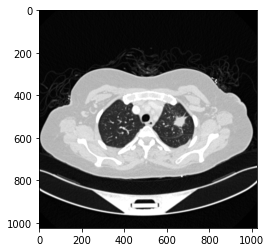

In [4]:
# Load dataset, output array
IMG_SIZE = 1024
TRAIN_DIR = '/gdrive/MyDrive/TomoGAN/Malignant_Tumor/train'
TEST_DIR = '/gdrive/MyDrive/TomoGAN/Malignant_Tumor/test'

#TRAIN_DIR = '/gdrive/MyDrive/TomoGAN/Fox_Images/Test/Clean_Test'

train_images = os.listdir(TRAIN_DIR)
test_images = os.listdir(TEST_DIR)

# Empty list for images after preprocess
train_list = []
test_list = []

# Get images in directory
for img in train_images:
    img_path = os.path.join(TRAIN_DIR, img)
    img = load_img(img_path, color_mode='grayscale', target_size = (IMG_SIZE, IMG_SIZE))
    img = img_to_array(img).astype('float32')/255
    train_list.append(img)

for img in test_images:
    img_path = os.path.join(TEST_DIR, img)
    img = load_img(img_path, color_mode='grayscale',  target_size = (IMG_SIZE, IMG_SIZE))
    img = img_to_array(img).astype('float32')/255
    test_list.append(img)

# Make lists numpy arrays     
x = np.array(train_list)
y = np.array(test_list)

# Show first image
print(f'Count: {len(x)}')
print(f'Shape: {x[0].shape}')
plt.imshow(tf.squeeze(x[0]), cmap='gray')

## Some helper functions

Preprocess verifies the array shape is acceptable for neural network. The Noise function adds random noise to a copy of the image. Noise factor can be manipulated to increase or decrease the noise. 

In [5]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMG_SIZE, IMG_SIZE, 1))
    return array

def new_noisy(img):
  img = x

  img = cv2.imread(img_path)[...,::-1]/255.0
  noise =  np.random.normal(loc=0, scale=1, size=img.shape)

  # noise overlaid over image
  noisy = np.clip((img + noise*0.2),0,1)

  return noisy

def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.5
    noisy_array = array + (noise_factor/1000) * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)
    

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(IMG_SIZE, IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(IMG_SIZE, IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

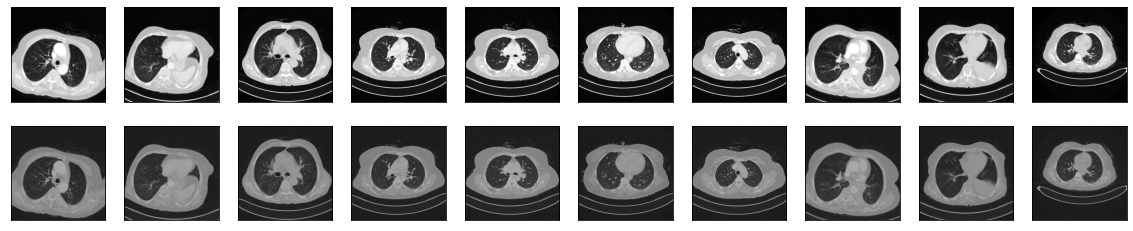

In [6]:
# Normalize and reshape the data
gt_img_train = preprocess(x)
gt_img_test = preprocess(y)

# Create a copy of the data with added noise
ns_img_train = noise(gt_img_train)
ns_img_test = noise(gt_img_test)

# Display the train data and a version of it with added noise
display(gt_img_train, ns_img_train)

Synthetic noise (left) and original image (right) compared

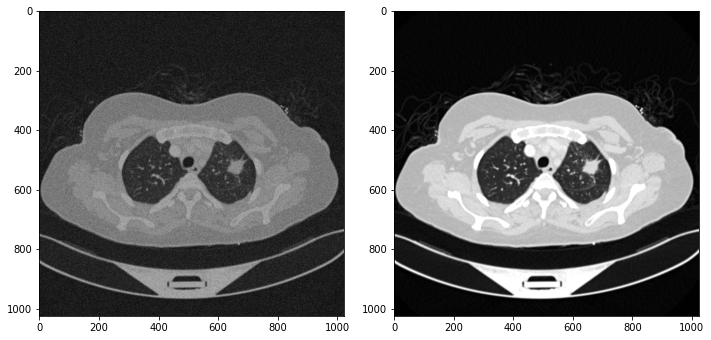

In [10]:
# visualize one of the pair
vis_idx = 0

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(tf.squeeze(ns_img_train[vis_idx]), cmap='gray')
plt.subplot(122)
plt.imshow(tf.squeeze(gt_img_train[vis_idx]), cmap='gray')
plt.tight_layout()
plt.show(); plt.close()

## Train a CNN for denoising in a supervised way

Because each image in the train and test dataset has been copied into the noisy datasets, we can build a CNN and use **supervised learning** to train the CNN model. Some key:



1.   Kernal: 3x3 array used to scan and filter the image
2.   Layers: contains height, width, and depth
    *   width, height: number of pixels
    *   depth: number of color channels per pixel
3.   Build: there are four interal loops for creating model
3.   Padding: to keep input/output volume size between the layers the same
4.   Activation: Rectified Linear unit (ReLU) 


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
print('Autoencoder')
Image(url= "https://d1zx6djv3kb1v7.cloudfront.net/wp-content/media/2019/09/Latent-space-representation-i2tutorials.png",width=600,height=300)

Autoencoder


## Build Model

Layers in the CNN model contain parameters that will be used to tune the training of the neural network. The breakdown of the model is as follows:

The number of parameters P in a layer is given by the kernel size K (9=3x3), the width W' of the previous layer, and the width W of the present layer, or P=(K x W'+1)x W. 

*   First internal layer, we get P1 = (3 x 3 x 1 +1) x 8=80, 
*   Second we get P2 = (3 x 3 x 8+1) x 16 = 73 x 16 = 1168. 
*   Third layer we get P3 = (3 x 3 x 16 + 1) x 8 = 1160, 
*   Fourth P4 = (3 x 3 x 8 + 1) x 4 = 292, 
*   Output layer P_out = (3 x 3 x 4 + 1) x 1 = 37. 

Thus, the total number of parameters to tune when we train the CNN is P1+P2+P3+P4+P_out=2737.


In [ ]:
## function to create a CNN model
def cnn4dn_mdl(input_shape, layer_width=(8, 16, 8, 4)):
    inputs = Input(shape=input_shape)
    _tmp   = inputs
    for _lw in layer_width:
        _tmp = Conv2D(filters=_lw, kernel_size=3, padding='same', activation='relu')(_tmp)
        
    # output layer, 1 kernel/channel, no activation
    _out = Conv2D(filters=1, kernel_size=3, padding='same', activation=None)(_tmp)
    
    return tf.keras.models.Model(inputs, _out)

In [ ]:
# create a model, 
tf.keras.backend.clear_session()
dn_mdl = cnn4dn_mdl(input_shape=(None, None, 1), layer_width=(8, 16, 8, 4))
dn_mdl.summary()

**Please allow 5-10 minutes for training.** 

After every 50 epochs, three images will appear in the following order: 

*   Synthetic Noise image
*   Target image
*   De-noised image

The goal is to minimize the loss function in each iteration when training the model.
 
*   Mini-batch size: number of images at a time to propagate through the network. 
    *   Parameters are updated after each iteration.
 
Optimization of the parameters: "Adam" optimizer from keras.

In [ ]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(20): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(tf.squeeze(dn_img), tf.squeeze(mb_y))

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 5 != 0: continue # let's check how model performs after every 50 epochs 
    if epoch == 0:
        val_X, val_y = ns_img_test[-1:,:,:,np.newaxis], gt_img_test[-1:]
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()

## Conclusion

Although the denoised images (right) above show a grainier solution than the target image (middle), it is still far more legible than the synthetic noise image (left). The noise factor was set fairly high and as a result, the blood vessels (or masses) were not clearly visible. After using CNN to train on the noisy images and compare it to the target images, the denoised image shows the areas of interest being sharper, more defined, and overall significantly clearer than the noisy images.

There are a few methods that could be used to further sharpen the denoised image. One way is to add more layers in the neural network, while another might be to increase the batch size per epoch. The loss function stayed relatively the same, which was close to zero, which might indicate that the images selected for denoising lacked high variability - and perhaps a greater distinction between the synthetic noise images and the denoised images would occur under a different set of images than CT lung scans. 


## TomoGAN

In [11]:
import shutil
# overwrite anyway 
if os.path.isdir('model'): 
    shutil.rmtree('model')
os.mkdir('model') # to save temp output

!wget -O model/TomoGAN.h5 https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/model/TomoGAN.h5

--2022-02-13 14:29:03--  https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/model/TomoGAN.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2854872 (2.7M) [application/octet-stream]
Saving to: ‘model/TomoGAN.h5’

model/TomoGAN.h5    100%[===================>]   2.72M  --.-KB/s    in 0.06s   

2022-02-13 14:29:03 (43.1 MB/s) - ‘model/TomoGAN.h5’ saved [2854872/2854872]



In [12]:
TomoGAN_mdl = tf.keras.models.load_model('model/TomoGAN.h5', )
TomoGAN_mdl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   16          ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   2336        ['conv2d[0][0]']                 
                                32)                                                           

In [14]:
ns_img_test_real = ns_img_train
gt_img_test_real = gt_img_train

print(f'ns shape: {ns_img_test[0].shape}')
print(f'gt shape: {gt_img_test[0].shape}')

ns shape: (1024, 1024, 1)
gt shape: (1024, 1024, 1)


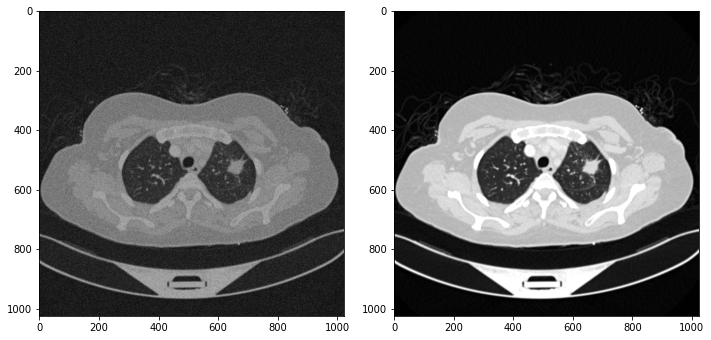

In [15]:
im = 0

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(tf.squeeze(ns_img_test_real[im]), cmap='gray')
plt.subplot(122)
plt.imshow(tf.squeeze(gt_img_test_real[im]), cmap='gray')
plt.tight_layout()
plt.show(); plt.close()

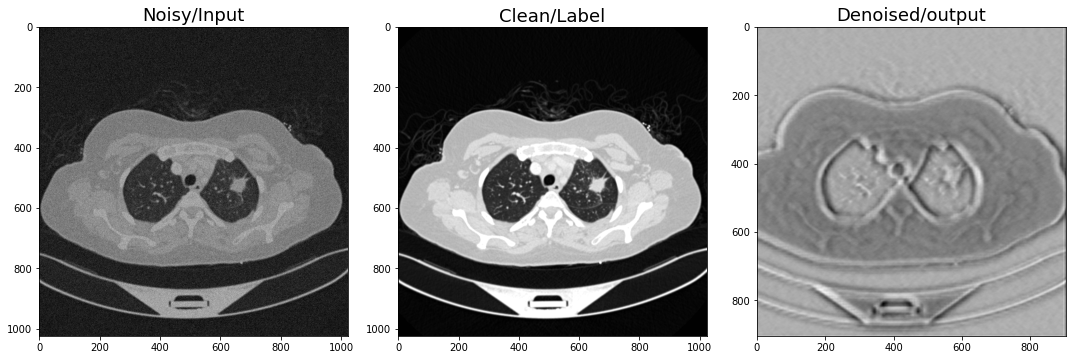

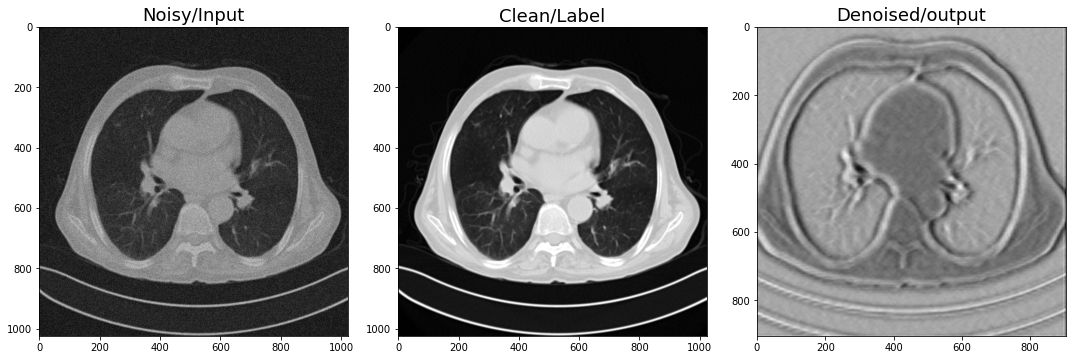

In [ ]:
import matplotlib.pyplot as plt


for _idx in range(ns_img_test_real.shape[0])[:2]:
    # just one line of code to denoise, need to remember that the input is four dimension [n, h, w, c] 
    dn_img = TomoGAN_mdl.predict(ns_img_test_real[_idx:_idx+1,:,:,np.newaxis]).squeeze()
    
    plt.figure(figsize=(15, 8))

    plt.subplot(131)
    plt.imshow(ns_img_test_real[_idx, :, :,0], cmap='gray')
    plt.title('Noisy/Input', fontsize=18)
    plt.subplot(132)
    plt.imshow(gt_img_test_real[_idx, :,:,0], cmap='gray')
    plt.title('Clean/Label', fontsize=18)
    plt.subplot(133)
    plt.imshow(dn_img[90:-30,90:-30])
    plt.title('Denoised/output', fontsize=18)
    plt.tight_layout(); plt.show(); plt.close()

In [16]:
batch_sz = 4
_idx = 0
tick = time.time()
dn_img = TomoGAN_mdl.predict(ns_img_test_real[_idx:_idx+batch_sz,:,:,np.newaxis]).squeeze()
print('It takes %.1f seconds to denoise %d, %dx%d images,' % (time.time() - tick, batch_sz, \
                                                            ns_img_test_real.shape[1],\
                                                            ns_img_test_real.shape[2]))
dn_img.shape

It takes 21.6 seconds to denoise 4, 1024x1024 images,


(4, 1024, 1024)

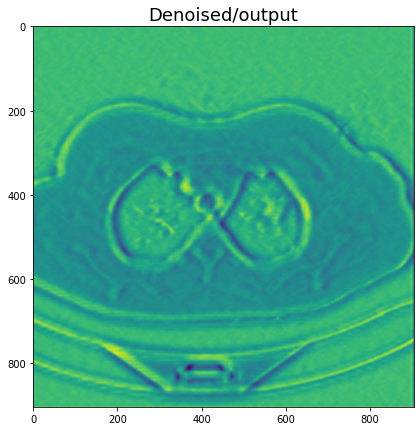

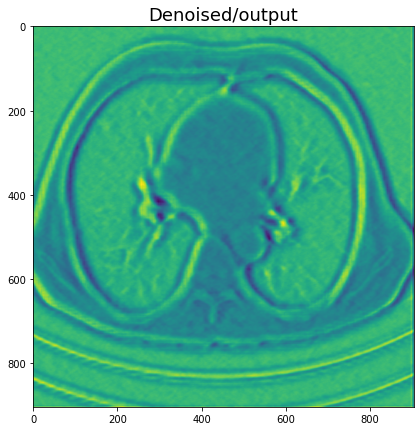

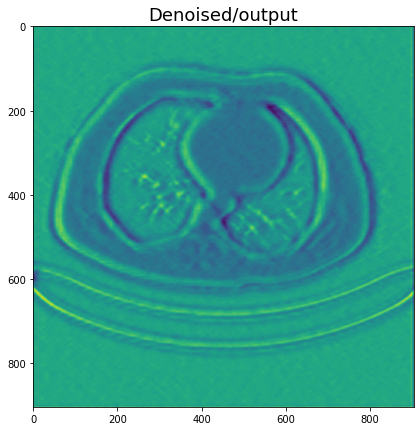

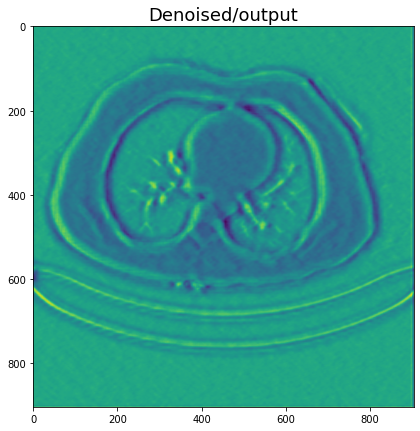

In [17]:
for _img_dn in dn_img:
    plt.figure(figsize=(7, 7))
    plt.imshow(_img_dn[90:-30, 90:-30], cmap='viridis')
    plt.title('Denoised/output', fontsize=18)
    plt.show(); plt.close()